In [1]:
# imports
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import warnings
import statistics as st                                                 # for statistical analysis
from sklearn.preprocessing import StandardScaler, normalize             # data scaling and normalization
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
pio.renderers
import pickle
warnings.filterwarnings("ignore")

In [2]:
# setting up several paths 
sys.path.append(".")
sys.path.append("..")
sys.path.insert(1, '../scripts')
from dataCleaner import *
from dataVisualizer import *

In [3]:
# read data
df = pd.read_csv('../data/Week1_challenge_data_source_filled.csv.bz2')
df

Bearer Id                Start  Start ms                  End  \
0       1.311450e+19  2019-04-04 12:01:00     770.0  2019-04-25 14:35:00   
1       1.311450e+19  2019-04-09 13:04:00     235.0  2019-04-25 08:15:00   
2       1.311450e+19  2019-04-09 17:42:00       1.0  2019-04-25 11:58:00   
3       1.311450e+19  2019-04-10 00:31:00     486.0  2019-04-25 07:36:00   
4       1.311450e+19  2019-04-12 20:10:00     565.0  2019-04-25 10:40:00   
...              ...                  ...       ...                  ...   
149995  1.304240e+19  2019-04-29 07:28:00     615.0  2019-04-30 00:01:00   
149996  7.277830e+18  2019-04-29 07:28:00     451.0  2019-04-30 06:02:00   
149997  7.349880e+18  2019-04-29 07:28:00     483.0  2019-04-30 10:41:00   
149998  1.311450e+19  2019-04-29 07:28:00     283.0  2019-04-30 10:46:00   
149999  1.311450e+19  2019-04-29 07:28:00     696.0  2019-04-30 10:40:00   

        End ms  Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0        662.0    86399.0  2.082010e+14   3.366496e+10  3.552120e+13   
1        606.0    86399.0  2.082020e+14   3.368185e+10  3.579400e+13   
2        652.0    86399.0  2.082000e+14   3.376063e+10  3.528150e+13   
3        171.0    86399.0  2.082010e+14   3.375034e+10  3.535660e+13   
4        954.0    86399.0  2.082010e+14   3.369980e+10  3.540700e+13   
...        ...        ...           ...            ...           ...   
149995   407.0    59587.0  2.082010e+14   3.366865e+10  3.533250e+13   
149996   214.0    81230.0  2.082020e+14   3.365069e+10  3.548310e+13   
149997   187.0    97970.0  2.082020e+14   3.366345e+10  3.566050e+13   
149998   810.0    98249.0  2.082020e+14   3.362189e+10  3.572120e+13   
149999   327.0    97910.0  2.082020e+14   3.361962e+10  8.618620e+13   

       Last Location Name  ...  total_youtube  total_netflix  total_social  \
0             9.16457E+15  ...     18355943.0     17855187.0     1570185.0   
1                 L77566A  ...     39359124.0     35565545.0     1933278.0   
2                 D42335A  ...     34425237.0     23751202.0     1726277.0   
3                 T21824A  ...     36534765.0     15092588.0      657493.0   
4                 D88865A  ...     34222253.0     17539799.0      912788.0   
...                   ...  ...            ...            ...           ...   
149995            T85721A  ...     24553645.0     29618711.0      993175.0   
149996            D20434A  ...     27955095.0     37561864.0     3517065.0   
149997            D10223C  ...     22165518.0     40643294.0     2352181.0   
149998            T51102A  ...     24516413.0     15029702.0     1260239.0   
149999            L88342B  ...     17122508.0     16494842.0      823109.0   

        total_other  fixed_dur  fixed_activity_dur_dl  fixed_activity_dur_ul  \
0       180558843.0    86399.0                37624.0                38787.0   
1       541959383.0    86399.0                  168.0                 3560.0   
2       414908351.0    86399.0                    0.0                    0.0   
3       761837216.0    86399.0                 3330.0                37882.0   
4       564619822.0    86399.0                    0.0                    0.0   
...             ...        ...                    ...                    ...   
149995  336273648.0    59587.0              3380381.0              2355730.0   
149996   16751926.0    81230.0                42376.0                41915.0   
149997  714638145.0    97970.0                17264.0                16759.0   
149998  132415585.0    98249.0                25003.0                28640.0   
149999  816120043.0    97910.0                13405.0                34088.0   

        fixed_total_ul   total_data               decile  
0           36749741.0  345629377.0   (72290.0, 86399.0]  
1           53800391.0  707185356.0   (72290.0, 86399.0]  
2           27883638.0  307690973.0   (72290.0, 86399.0]  
3           43324218.0  889352748.0   (72290.0, 86399.0]  
4           38542814.0  607681403.0   (7

In [4]:
# create a df cleaner instance
cleaner = dataCleaner()
visualizer = dataVisualizer()

Data cleaner in action.
Data visualizer in action.


# User engagement analysis
* Tracking the user engagement based on session frequency, duration of session, and total traffic (UL+DL) on the network

#### Aggregating the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

In [5]:
user_engagement_df = df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms)', 'total_data']]

user_engagement_df = user_engagement_df.groupby('MSISDN/Number').agg(
    {'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'total_data': 'sum'})
user_engagement_df = user_engagement_df.rename(columns={'Bearer Id': 'XDR Sessions'})
user_engagement_df

XDR Sessions  Dur. (ms)    total_data
MSISDN/Number                                       
3.360100e+10              1   116720.0  8.786906e+08
3.360100e+10              1   181230.0  1.568596e+08
3.360100e+10              1   134969.0  5.959665e+08
3.360101e+10              1    49878.0  4.223207e+08
3.360101e+10              2    37104.0  1.457411e+09
...                     ...        ...           ...
3.379000e+10              1     8810.0  7.146416e+08
3.379000e+10              1   140988.0  4.803073e+08
3.197020e+12              1    86399.0  2.321240e+08
3.370000e+14              1    86399.0  5.962878e+08
8.823970e+14              1    86399.0  1.198409e+08

[106856 rows x 3 columns]

In [6]:
user_engagement_df['XDR Sessions'].value_counts()

1       77730
2       21452
3        4422
4        1950
5         938
6         208
7          75
8          34
9          17
10         12
12          5
11          5
17          2
15          2
18          1
16          1
1066        1
13          1
Name: XDR Sessions, dtype: int64

In [7]:
user_engagement_df['Dur. (ms)'].value_counts()

86399.0      11058
86400.0       2015
172798.0      1430
172799.0       719
259197.0       324
             ...  
1747994.0        1
135151.0         1
343837.0         1
269535.0         1
140988.0         1
Name: Dur. (ms), Length: 73943, dtype: int64

In [8]:
user_engagement_df['total_data'].value_counts()

4.770374e+08    2
6.377260e+08    2
3.212946e+08    2
3.752936e+08    2
1.493950e+09    1
               ..
9.172005e+08    1
8.083349e+08    1
6.432406e+08    1
8.967577e+07    1
1.198409e+08    1
Name: total_data, Length: 106852, dtype: int64

In [9]:
#  top 10 customers per engagement metric - XDR sessions
user_engagement_df.nlargest(10, 'XDR Sessions')

XDR Sessions   Dur. (ms)    total_data
MSISDN/Number                                        
3.366371e+10           1066  63940818.0  5.302862e+11
3.362632e+10             18   1785419.0  7.951348e+09
3.361489e+10             17   1678397.0  8.826326e+09
3.362578e+10             17   1599052.0  8.474657e+09
3.365973e+10             16   1905478.0  7.680848e+09
3.367588e+10             15   1745131.0  7.891111e+09
3.376054e+10             15   1651084.0  8.495067e+09
3.366716e+10             13   1209703.0  5.618394e+09
3.360313e+10             12   1109736.0  4.976195e+09
3.360452e+10             12   1193033.0  5.487855e+09

* These are the top 10 users per the XDR session engagement metric

In [10]:
#  top 10 customers per engagement metric - Durations
user_engagement_df.nlargest(10, 'Dur. (ms)')

XDR Sessions   Dur. (ms)    total_data
MSISDN/Number                                        
3.366371e+10           1066  63940818.0  5.302862e+11
3.365973e+10             16   1905478.0  7.680848e+09
3.362632e+10             18   1785419.0  7.951348e+09
3.365936e+10             11   1747994.0  4.658437e+09
3.367588e+10             15   1745131.0  7.891111e+09
3.361489e+10             17   1678397.0  8.826326e+09
3.376054e+10             15   1651084.0  8.495067e+09
3.362578e+10             17   1599052.0  8.474657e+09
3.378632e+10             12   1427807.0  5.622232e+09
3.366471e+10             11   1334982.0  6.852224e+09

* These are the top 10 users per the duration of session engagement metric

In [11]:
#  top 10 customers per engagement metric - total data volume
user_engagement_df.nlargest(10, 'total_data')

XDR Sessions   Dur. (ms)    total_data
MSISDN/Number                                        
3.366371e+10           1066  63940818.0  5.302862e+11
3.361489e+10             17   1678397.0  8.826326e+09
3.376054e+10             15   1651084.0  8.495067e+09
3.362578e+10             17   1599052.0  8.474657e+09
3.362632e+10             18   1785419.0  7.951348e+09
3.367588e+10             15   1745131.0  7.891111e+09
3.365973e+10             16   1905478.0  7.680848e+09
3.366646e+10             11   1168703.0  7.308501e+09
3.376041e+10             12   1248477.0  7.112835e+09
3.366471e+10             11   1334982.0  6.852224e+09

* These are the top 10 users per the total data (UL + DL) engagement metric

#### Normalizing each engagement metric and runing a k-means (k=3) to classify customers in three groups of engagement. 

In [12]:
# Data Scaling and normalization
# Data Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_engagement_df)
print(type(scaled_data), scaled_data)

# Data Normalization
normalized_data = normalize(scaled_data)
print(type(normalized_data), normalized_data)

<class 'numpy.ndarray'> [[-0.12034413 -0.05434193  0.10890723]
 [-0.12034413  0.23939902 -0.31753898]
 [-0.12034413  0.02875338 -0.05812166]
 ...
 [-0.12034413 -0.19240609 -0.27307401]
 [-0.12034413 -0.19240609 -0.05793181]
 [-0.12034413 -0.19240609 -0.33940905]]
<class 'numpy.ndarray'> [[-0.70309945 -0.31748768  0.63628039]
 [-0.28964919  0.57619537 -0.76426582]
 [-0.88033551  0.21033535 -0.42516871]
 ...
 [-0.33893405 -0.54188746 -0.76907847]
 [-0.51380856 -0.82147667 -0.24733954]
 [-0.29475108 -0.47124776 -0.83129258]]


In [13]:
# k means clustering based on 3 clusters
k_means = KMeans(n_clusters=3, random_state=777).fit(normalized_data)
print(type(k_means.labels_), len(k_means.labels_), k_means.labels_)
print(np.unique(k_means))

<class 'numpy.ndarray'> 106856 [1 2 2 ... 1 1 1]
[KMeans(n_clusters=3, random_state=777)]


In [14]:
# insert the cluster of the data inside the dataframe
user_engagement_df.insert(0, 'cluster', k_means.labels_)
user_engagement_df.cluster.value_counts()

1    60162
0    24879
2    21815
Name: cluster, dtype: int64

We can see 3 clusters has been added

In [15]:
# the data frame with clusters added
user_engagement_df

cluster  XDR Sessions  Dur. (ms)    total_data
MSISDN/Number                                                
3.360100e+10         1             1   116720.0  8.786906e+08
3.360100e+10         2             1   181230.0  1.568596e+08
3.360100e+10         2             1   134969.0  5.959665e+08
3.360101e+10         1             1    49878.0  4.223207e+08
3.360101e+10         1             2    37104.0  1.457411e+09
...                ...           ...        ...           ...
3.379000e+10         1             1     8810.0  7.146416e+08
3.379000e+10         2             1   140988.0  4.803073e+08
3.197020e+12         1             1    86399.0  2.321240e+08
3.370000e+14         1             1    86399.0  5.962878e+08
8.823970e+14         1             1    86399.0  1.198409e+08

[106856 rows x 4 columns]

In [16]:
# visualizing the 3 clusters in the dataframe
# for 20, 000 samples only
fig = px.scatter(user_engagement_df.sample(20000), x='total_data', y='Dur. (ms)',
                 color='cluster', size='XDR Sessions')
fig.update_traces(marker_size=8)
fig.update(layout_yaxis_range = [0, 800000])
fig.update(layout_xaxis_range = [0, 4000000000])
fig.show()

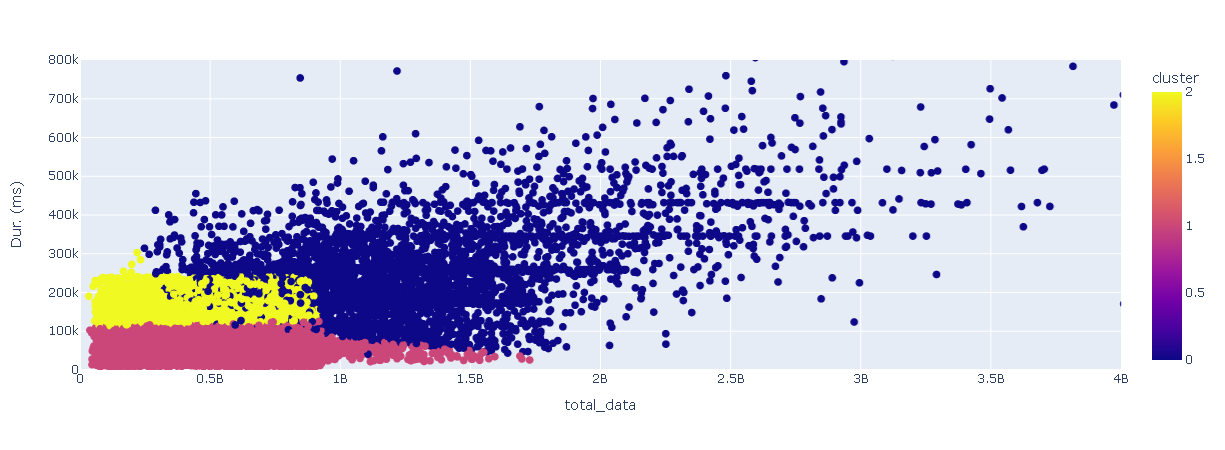

In [17]:
# this is just for git hub, to display the plot on git hub
Image(filename='../plots/3_cluster_scatter.png')

The scatter plot based on the 3 clusters
* color indicates the clusters
* size of points indicate the XDR sessions

#### Computing the minimum, maximum, average & other metrics for total non-normalized metrics for each cluster

In [18]:
cleaner.computeBasicAnalysisOnClusters(user_engagement_df, cluster_col = 'cluster', cluster_size = len(user_engagement_df.cluster.value_counts().keys()), cols = ['XDR Sessions', 'Dur. (ms)', 'total_data'])

Cluster I
       XDR Sessions     Dur. (ms)    total_data
count  24879.000000  2.487900e+04  2.487900e+04
mean       2.555529  2.496147e+05  1.294933e+09
std        6.815382  4.236554e+05  3.407945e+09
min        1.000000  3.195800e+04  2.014465e+08
25%        2.000000  1.727980e+05  8.864466e+08
50%        2.000000  2.182310e+05  1.166192e+09
75%        3.000000  3.042965e+05  1.528738e+09
max     1066.000000  6.394082e+07  5.302862e+11


Cluster II
       XDR Sessions      Dur. (ms)    total_data
count  60162.000000   60162.000000  6.016200e+04
mean       1.069030   67050.050979  5.246188e+08
std        0.253639   30377.299741  2.645020e+08
min        1.000000    7142.000000  3.324901e+07
25%        1.000000   37051.000000  3.053978e+08
50%        1.000000   84206.000000  5.242809e+08
75%        1.000000   86400.000000  7.338753e+08
max        3.000000  126213.000000  1.749061e+09


Cluster III
       XDR Sessions      Dur. (ms)    total_data
count  21815.000000   21815.000000  2.181

Insights on clusters

* cluster I: total count 24, 879
    * XDR session
        * Has a standard deviation of 6.815382
        * Relatively normal value for standard deviation
        * With a min of 1 and max of 1,066 value
    * Duration (ms)
        * Has a standard deviation of 423,655.4
        * Relatively high value for standard deviation
        * With a min of 3,1958 and max of 6,394,082 value
    * Total data
        * Has a standard deviation of 3407945.e+03
        * Relatively high value for standard deviation
        * With a min of 2.014465e+08 and max of 5.302862e+11 value

* cluster II: total count 60, 162
    * XDR session
        * Has a standard deviation of 0.253639
        * Relatively lower value for standard deviation
        * With a min of 1 and max of 3 value
    * Duration (ms)
        * Has a standard deviation of 30377.299741
        * Relatively higher value for standard deviation
        * With a min of 7,142 and max of 126,213 value
    * Total data
        * Has a standard deviation of 2.645020e+08
        * Relatively higher value for standard deviation
        * With a min of 3.324901e+07 and max of 1.749061e+09 value

* cluster III: total count 21, 815
    * XDR session
        * Has a standard deviation of 0.114726
        * Relatively lower value for standard deviation
        * With a min of 1 and max of 2 value
    * Duration (ms)
        * Has a standard deviation of 29,080
        * Relatively lower value for standard deviation
        * With a min of 113,146 and max of 407,713 value
    * Total data
        * Has a standard deviation of 2.420226e+08
        * Relatively lower value for standard deviation
        * With a min of 3.357584e+07 and max of 9.396428e+08 value

#### Aggregating user total traffic per application and deriving the top 10 most engaged users per application

In [19]:
user_app_engagement_df = df[['MSISDN/Number', 'total_social', 'total_google',
    'total_email', 'total_youtube', 'total_netflix',
    'total_gaming', 'total_other', 'total_data']]
user_app_engagement_df

MSISDN/Number  total_social  total_google  total_email  total_youtube  \
0        3.366496e+10     1570185.0     2905912.0    3701304.0     18355943.0   
1        3.368185e+10     1933278.0     4414096.0     937385.0     39359124.0   
2        3.376063e+10     1726277.0    10229119.0    3363124.0     34425237.0   
3        3.375034e+10      657493.0    11811761.0    2070983.0     36534765.0   
4        3.369980e+10      912788.0     7748843.0    2110349.0     34222253.0   
...               ...           ...           ...          ...            ...   
149995   3.366865e+10      993175.0     1265634.0    4280107.0     24553645.0   
149996   3.365069e+10     3517065.0    12784914.0     690876.0     27955095.0   
149997   3.366345e+10     2352181.0     4415361.0    2121718.0     22165518.0   
149998   3.362189e+10     1260239.0     6585469.0    2058277.0     24516413.0   
149999   3.361962e+10      823109.0     7757267.0    2850914.0     17122508.0   

        total_netflix  total_gaming  total_other   total_data  
0          17855187.0   292426453.0  180558843.0  345629377.0  
1          35565545.0   609920783.0  541959383.0  707185356.0  
2          23751202.0   229980251.0  414908351.0  307690973.0  
3          15092588.0   810387875.0  761837216.0  889352748.0  
4          17539799.0   531237049.0  564619822.0  607681403.0  
...               ...           ...          ...          ...  
149995     29618711.0   797160102.0  336273648.0  872761860.0  
149996     37561864.0   535806880.0   16751926.0  631804110.0  
149997     40643294.0   631628095.0  714638145.0  705783925.0  
149998     15029702.0   566933800.0  132415585.0  627698629.0  
149999     16494842.0   355066446.0  816120043.0  401522016.0  

[150000 rows x 9 columns]

* total users and their activity engagement per application

In [20]:
# total users and their activity engagement per application
total_application_data_per_user = user_app_engagement_df.groupby('MSISDN/Number').sum()
total_application_data_per_user

total_social  total_google  total_email  total_youtube  \
MSISDN/Number                                                           
3.360100e+10      2232135.0     4389005.0    1331362.0     21624548.0   
3.360100e+10      2660565.0     5334863.0    3307781.0     12432223.0   
3.360100e+10      3195623.0     3443126.0    3205380.0     21333570.0   
3.360101e+10       280294.0     9678493.0    2284670.0      6977321.0   
3.360101e+10      2912542.0    18499616.0    3305469.0     41533002.0   
...                     ...           ...          ...            ...   
3.379000e+10       300183.0     7531269.0    1006915.0     26647843.0   
3.379000e+10       498569.0     5429705.0    2514097.0     19851572.0   
3.197020e+12       715224.0    10438660.0    1520771.0     11959905.0   
3.370000e+14       521566.0     9830617.0    3318582.0     36734940.0   
8.823970e+14      1546088.0     9218647.0    3330974.0     40940710.0   

               total_netflix  total_gaming  total_other    total_data  
MSISDN/Number                                                          
3.360100e+10      27180981.0  8.124587e+08  386570872.0  8.786906e+08  
3.360100e+10      11221763.0  1.197501e+08  281710071.0  1.568596e+08  
3.360100e+10      19353900.0  5.388277e+08  501693672.0  5.959665e+08  
3.360101e+10       1942092.0  3.911261e+08   35279702.0  4.223207e+08  
3.360101e+10      49201724.0  1.314798e+09  804804484.0  1.457411e+09  
...                      ...           ...          ...           ...  
3.379000e+10      14902538.0  6.603614e+08  295282817.0  7.146416e+08  
3.379000e+10       8531060.0  4.370033e+08  211115113.0  4.803073e+08  
3.197020e+12      26592300.0  1.780487e+08  470526473.0  2.321240e+08  
3.370000e+14      30905042.0  5.101427e+08  149188439.0  5.962878e+08  
8.823970e+14      28846230.0  4.307026e+07  401360457.0  1.198409e+08  

[106856 rows x 8 columns]

* Top 10 users of social media

In [21]:
# social media
social_media = total_application_data_per_user.nlargest(10, "total_social")['total_social']
social_media

MSISDN/Number
3.366371e+10    1.972371e+09
3.362632e+10    4.337478e+07
3.376054e+10    3.978319e+07
3.365973e+10    3.541236e+07
3.361489e+10    2.829454e+07
3.362578e+10    2.713550e+07
3.366716e+10    2.424785e+07
3.378632e+10    2.397492e+07
3.366907e+10    2.380083e+07
3.360313e+10    2.307782e+07
Name: total_social, dtype: float64

* Top 10 users of Goggle

In [22]:
# goggle
google = total_application_data_per_user.nlargest(10, "total_google")['total_google']
google

MSISDN/Number
3.366371e+10    8.242894e+09
3.362632e+10    1.521919e+08
3.362578e+10    1.423079e+08
3.361489e+10    1.279738e+08
3.376054e+10    1.232231e+08
3.365973e+10    1.165163e+08
3.378632e+10    1.102545e+08
3.367588e+10    1.098605e+08
3.366716e+10    1.050327e+08
3.376127e+10    9.708999e+07
Name: total_google, dtype: float64

* Top 10 users of Email

In [23]:
# email
email = total_application_data_per_user.nlargest(10, "total_email")['total_email']
email

MSISDN/Number
3.366371e+10    2.401363e+09
3.362632e+10    4.241878e+07
3.361489e+10    4.078863e+07
3.362578e+10    4.063397e+07
3.378632e+10    3.631012e+07
3.365973e+10    3.599979e+07
3.376054e+10    3.369377e+07
3.367588e+10    3.151442e+07
3.366546e+10    3.041788e+07
3.366716e+10    3.033580e+07
Name: total_email, dtype: float64

* Top 10 users of Youtube

In [24]:
# youtube
youtube = total_application_data_per_user.nlargest(10, "total_youtube")['total_youtube']
youtube

MSISDN/Number
3.366371e+10    2.432808e+10
3.362578e+10    4.529588e+08
3.376054e+10    3.962892e+08
3.361489e+10    3.943702e+08
3.362632e+10    3.744830e+08
3.367588e+10    3.174106e+08
3.366716e+10    3.152313e+08
3.362708e+10    3.087908e+08
3.376041e+10    3.031691e+08
3.369879e+10    3.026620e+08
Name: total_youtube, dtype: float64

* Top 10 users of Netflix

In [25]:
# netflix
netflix = total_application_data_per_user.nlargest(10, "total_netflix")['total_netflix']
netflix

MSISDN/Number
3.366371e+10    2.425948e+10
3.365973e+10    3.995191e+08
3.361489e+10    3.614010e+08
3.362578e+10    3.569806e+08
3.376054e+10    3.346433e+08
3.362632e+10    3.287257e+08
3.376041e+10    3.183475e+08
3.366716e+10    3.139395e+08
3.367588e+10    3.090932e+08
3.378632e+10    3.059398e+08
Name: total_netflix, dtype: float64

* Top 10 users of Gaming

In [26]:
# netflix
gaming = total_application_data_per_user.nlargest(10, "total_gaming")['total_gaming']
gaming

MSISDN/Number
3.366371e+10    4.612043e+11
3.361489e+10    7.749432e+09
3.376054e+10    7.461045e+09
3.362578e+10    7.326673e+09
3.367588e+10    6.970568e+09
3.362632e+10    6.887572e+09
3.365973e+10    6.725559e+09
3.366646e+10    6.646303e+09
3.376041e+10    6.268620e+09
3.366471e+10    6.103856e+09
Name: total_gaming, dtype: float64

* Top 10 users of Other applications

In [27]:
# other
other = total_application_data_per_user.nlargest(10, "total_other")['total_other']
other

MSISDN/Number
3.366371e+10    4.512228e+11
3.362632e+10    8.167878e+09
3.361489e+10    7.639264e+09
3.367588e+10    6.798515e+09
3.362578e+10    6.354583e+09
3.360313e+10    6.326671e+09
3.365973e+10    6.317415e+09
3.362695e+10    5.305448e+09
3.362708e+10    5.117791e+09
3.376127e+10    5.077779e+09
Name: total_other, dtype: float64

#### Plotting the top 3 most used applications using appropriate charts

In [28]:
# top 3 most used apps 

user_app_engagement_dfx = total_application_data_per_user[['total_social', 'total_google','total_email', 'total_youtube', 'total_netflix','total_gaming']]
top_3_apps = user_app_engagement_dfx.sum().sort_values(ascending=False)
top_3_apps

total_gaming     6.454997e+13
total_youtube    3.396522e+12
total_netflix    3.394291e+12
total_google     1.171094e+12
total_email      3.388653e+11
total_social     2.742375e+11
dtype: float64

Text(0.5, 1.0, 'top 3 most used apps')

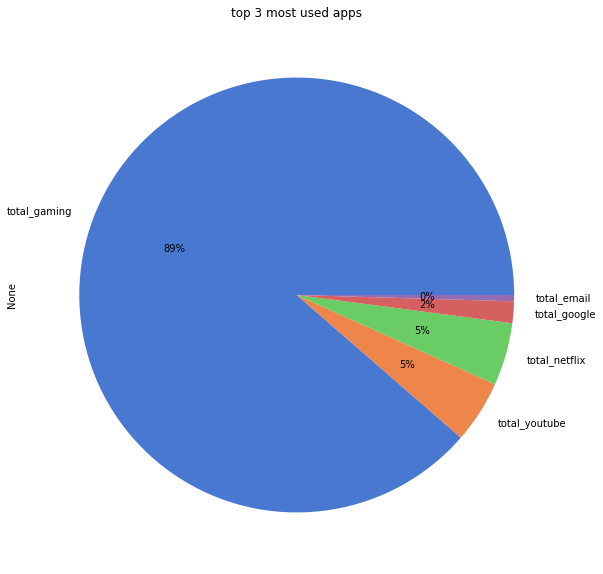

In [29]:
# Generate plot on top 3 most used apps 
fig = plt.figure(figsize = (10,10))
last_num = len(top_3_apps.head(5).values)
colors = sns.color_palette('muted')[0:last_num]
top_3_apps.head(5).plot.pie(grid=True, colors=colors, autopct='%.000f%%')
plt.title('top 3 most used apps')

* The top 3 applications used are
    * Gaming
    * Youtube
    * Netflix
    
As we can see gaming alone have the largest (89%) use per application, next to Youtube (5%) and Netflix (5%).

#### Grouping users in k engagement clusters based on the engagement metrics

In [30]:
# here goes

In [31]:
distortions, inertias = cleaner.choose_k_means(normalized_data, 20)
fig = make_subplots(rows=1, cols=2, subplot_titles=("Distortion", "Inertia"))
fig.add_trace(go.Scatter(x=np.array(range(1, 20)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 20)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method", height=500)
fig.show()

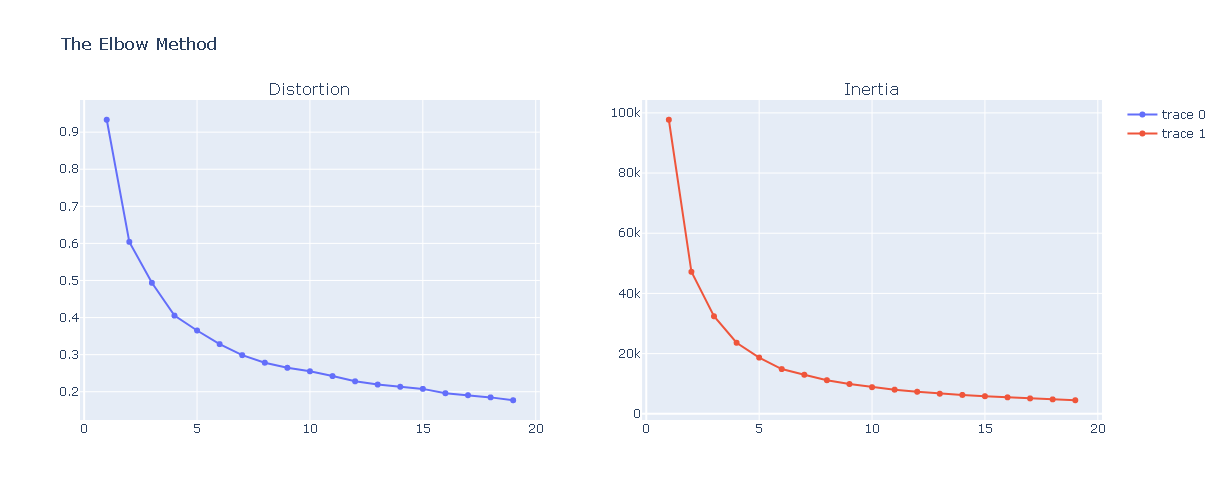

In [32]:
# this is just for git hub, to display the plot on git hub
Image(filename='../plots/elbow_method.png')

In [33]:
# k=4 is the value, so its good to make 4 clusters

kmeans = KMeans(n_clusters=4, random_state=777).fit(normalized_data)
kmeans.labels_

array([2, 3, 3, ..., 1, 2, 1])

In [34]:
with open("../models/user_engagement_cluster.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [35]:
# add the new clusters to the data frame
user_engagement_df["best_cluster"]= kmeans.labels_

In [36]:
# display the new clusters and their count
user_engagement_df.best_cluster.value_counts()

1    34185
2    30157
0    23505
3    19009
Name: best_cluster, dtype: int64

* New cluster plot based on the 4 clusters, calculate using the elbow method

In [37]:
fig = px.scatter(user_engagement_df, x='total_data', y='Dur. (ms)',
                 color='best_cluster', size='XDR Sessions')
fig.update_traces(marker_size=8)
fig.update(layout_yaxis_range = [0, 2000000])
fig.update(layout_xaxis_range = [0, 5000000000])
fig.show()

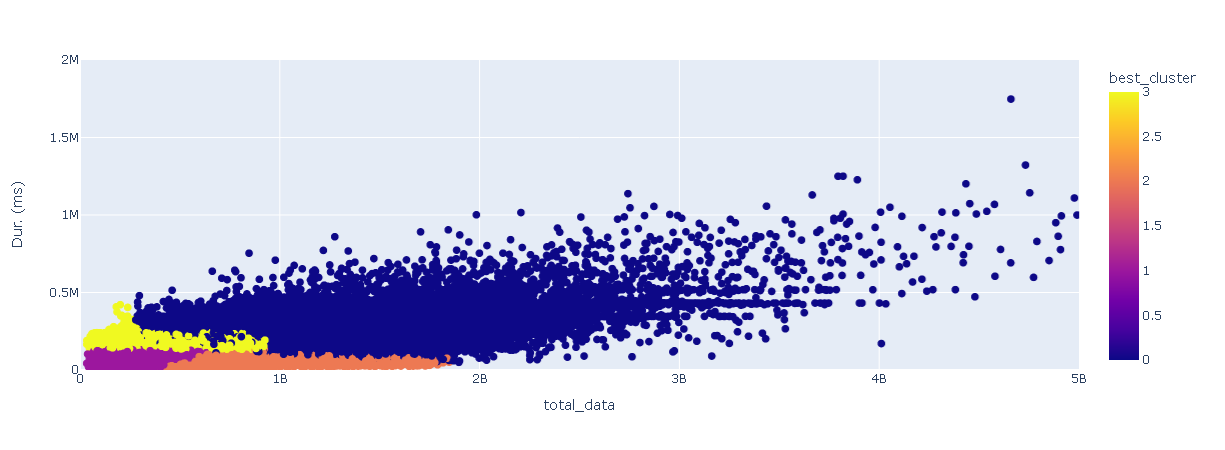

In [38]:
# this is just for git hub, to display the plot on git hub
Image(filename='../plots/4_cluster_scatter.png')

* looking at the data frames for the last time to check for errors

In [39]:
user_engagement_df.to_csv('../data/user_engagement.csv.bz2')
print('file saved successfully')
user_engagement_df

file saved successfully


cluster  XDR Sessions  Dur. (ms)    total_data  best_cluster
MSISDN/Number                                                              
3.360100e+10         1             1   116720.0  8.786906e+08             2
3.360100e+10         2             1   181230.0  1.568596e+08             3
3.360100e+10         2             1   134969.0  5.959665e+08             3
3.360101e+10         1             1    49878.0  4.223207e+08             1
3.360101e+10         1             2    37104.0  1.457411e+09             2
...                ...           ...        ...           ...           ...
3.379000e+10         1             1     8810.0  7.146416e+08             2
3.379000e+10         2             1   140988.0  4.803073e+08             3
3.197020e+12         1             1    86399.0  2.321240e+08             1
3.370000e+14         1             1    86399.0  5.962878e+08             2
8.823970e+14         1             1    86399.0  1.198409e+08             1

[106856 rows x 5 columns]

In [40]:
user_app_engagement_df.to_csv('../data/user_app_engagement.csv.bz2', index=False)
print('file saved successfully')
user_app_engagement_df

file saved successfully


MSISDN/Number  total_social  total_google  total_email  total_youtube  \
0        3.366496e+10     1570185.0     2905912.0    3701304.0     18355943.0   
1        3.368185e+10     1933278.0     4414096.0     937385.0     39359124.0   
2        3.376063e+10     1726277.0    10229119.0    3363124.0     34425237.0   
3        3.375034e+10      657493.0    11811761.0    2070983.0     36534765.0   
4        3.369980e+10      912788.0     7748843.0    2110349.0     34222253.0   
...               ...           ...           ...          ...            ...   
149995   3.366865e+10      993175.0     1265634.0    4280107.0     24553645.0   
149996   3.365069e+10     3517065.0    12784914.0     690876.0     27955095.0   
149997   3.366345e+10     2352181.0     4415361.0    2121718.0     22165518.0   
149998   3.362189e+10     1260239.0     6585469.0    2058277.0     24516413.0   
149999   3.361962e+10      823109.0     7757267.0    2850914.0     17122508.0   

        total_netflix  total_gaming  total_other   total_data  
0          17855187.0   292426453.0  180558843.0  345629377.0  
1          35565545.0   609920783.0  541959383.0  707185356.0  
2          23751202.0   229980251.0  414908351.0  307690973.0  
3          15092588.0   810387875.0  761837216.0  889352748.0  
4          17539799.0   531237049.0  564619822.0  607681403.0  
...               ...           ...          ...          ...  
149995     29618711.0   797160102.0  336273648.0  872761860.0  
149996     37561864.0   535806880.0   16751926.0  631804110.0  
149997     40643294.0   631628095.0  714638145.0  705783925.0  
149998     15029702.0   566933800.0  132415585.0  627698629.0  
149999     16494842.0   355066446.0  816120043.0  401522016.0  

[150000 rows x 9 columns]